In [75]:
import numpy as np
import matplotlib.pyplot as plt
# fix issues with tex
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from setup import init_particles, init_A, init_V
from update_rules import update_state, update_A, update_V
from visualize import visualize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# Parameters
n = 20          # Total number of particles
T = 200          # Total simulation time
dt = 0.1        # Time step
num_steps = int(T/dt) + 1
d = 2           # Dimensionality (2D)

integration_time = np.linspace(0, T, num_steps)

In [107]:
def init_V(d):
    V = 2*np.random.rand(d, d)-np.ones((d, d))
    V = np.matmul(V, V.T)
    return V

def init_A_eye(d):
    return np.eye(d)

def init_A(d):
    A = 2*np.random.rand(d, d)-np.ones((d, d))
    A = np.matmul(A, A.T)
    return A

def init_x(n, d, num_steps):
    x0 = np.random.uniform(low=-1, high=1, size=(n, d))
    x = np.zeros(shape=(n, num_steps, d))
    x[:, 0, :] = x0
    return x

def init_x_clusters(n, d, num_steps):
    # Let's create two clusters
    n_clusters = 2
    noise = 0.2
    cluster_sep = 2.0
    # clusters mirrored across the origin
    # cluster_centers = [np.array([-cluster_sep/2] * d), np.array([cluster_sep/2] * d)]
    cluster_centers = [np.array([0] * d), np.array([10] * d)]
    x0 = np.zeros((n, d))
    for i in range(n):
        cluster_idx = i % n_clusters
        x0[i] = cluster_centers[cluster_idx] + np.random.normal(scale=noise, size=d)
    x = np.zeros((n, num_steps, d))
    x[:, 0, :] = x0
    return x

def euler_update(attention, V, x, n, dt):
    # TODO: add additional update rules to particle location based on FFN, norm, etc
    for i in range(n):
        dlst = np.array([attention[i][j]*np.matmul(V, x[j][l]) for j in range(n)])
        # sum over j
        dynamics = np.sum(dlst, axis=0)
        # Euler scheme
        x[i][l+1] = x[i][l] + dt*dynamics
    return x

In [110]:
# Define A, V, x
scale = 1.0 # no scaling if 1
V = init_V(d) * scale
A = init_A_eye(d) * scale
print(A)
x = init_x_clusters(n, d, num_steps)

# for adding classification objective
labels = np.array([0]*10 + [1]*10)
classification_task = False
learning_rate = 0.01

# for MOS experimetns
K = 2 # num mixture compoennts
pi = np.random.rand(K)
pi /= np.sum(pi)  # Normalize to sum to 1
h = np.random.randn(K, d)  # Context vectors

# visualization cadence params
viz_cadence = 1
kmeans_cadence = 1

[[1. 0.]
 [0. 1.]]


## Original Experiments

Low Rank Analysis and cluster divergence

In [111]:
def compute_attention(A, x, i, j, n):
    """
    Compute attention weight using a softmax-like mechanism for numerical stability.
    
    Args:
        A (np.ndarray): Transformation matrix A of shape (d, d).
        x (np.ndarray): Current particle positions of shape (n, d).
        i (int): Index of the query particle.
        j (int): Index of the key particle.
        n (int): Total number of particles.
    
    Returns:
        float: Attention weight between particle i and j.
    """
    scores = [np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l]) for k in range(n)]
    # Apply softmax in a numerically stable way
    max_score =  np.max(scores) # np.zeros_like(scores)
    exp_scores = np.exp(scores - max_score)
    sum_exp = np.sum(exp_scores)
    attention_weight = 1 / sum_exp
    return attention_weight

def compute_attn_mos(A, x, i, j, n, h, pi):
    attention = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                continue  # Optional: No self-attention
            scores = []
            for k in range(K):
                # Compute similarity score for mixture component k
                # Adjust the formula based on MoS requirements
                # Here, a simplified dot product is used; adapt as needed
                score = np.dot(h[k], A @ x[i, l]) * np.dot(A @ x[i, l], x[j, l] - x[i, l])
                scores.append(score)
            scores = np.array(scores)  # Shape: (K,)
            # Apply softmax to scores for numerical stability
            max_score = np.max(scores)
            exp_scores = np.exp(scores - max_score)
            softmax_scores = exp_scores / np.sum(exp_scores)
            # Combine softmax scores using mixture weights pi
            attention[i, j] = np.dot(pi, softmax_scores)
    return attention

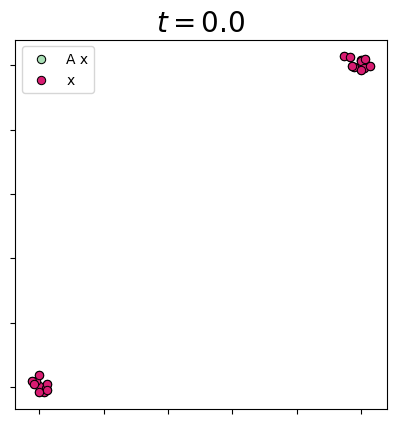

[[ 9.91829917 10.07466875]
 [ 0.02426459  0.04684853]]
Time 0.00: Silhouette Score = 0.9760 Distance between cluster centers = 14.0872


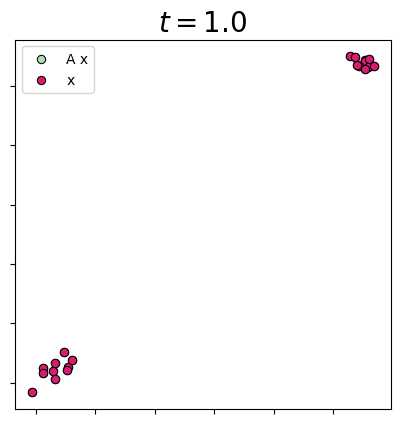

[[23.00288637 18.78518355]
 [12.64017352  8.43915453]]
Time 1.00: Silhouette Score = 0.9632 Distance between cluster centers = 14.6433


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


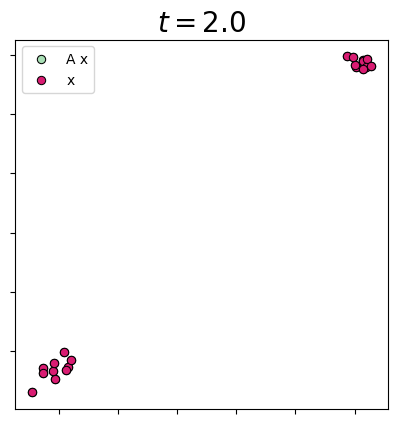

[[43.85963474 23.35836847]
 [54.19289318 33.74331719]]
Time 2.00: Silhouette Score = 0.9630 Distance between cluster centers = 14.6500


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


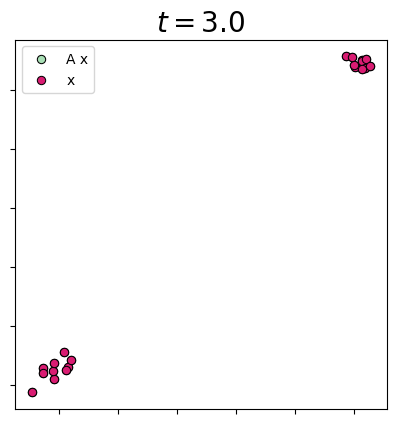

[[119.85238205  46.50809424]
 [130.172424    56.9079428 ]]
Time 3.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


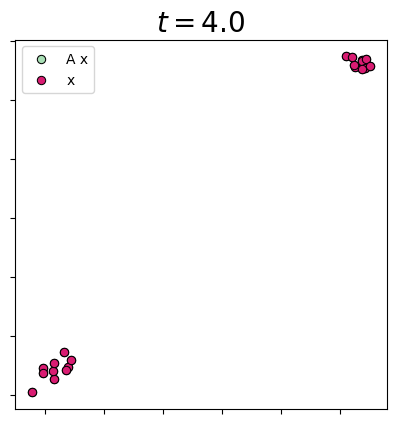

[[318.66449296  85.2502149 ]
 [308.3444716   74.85034317]]
Time 4.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


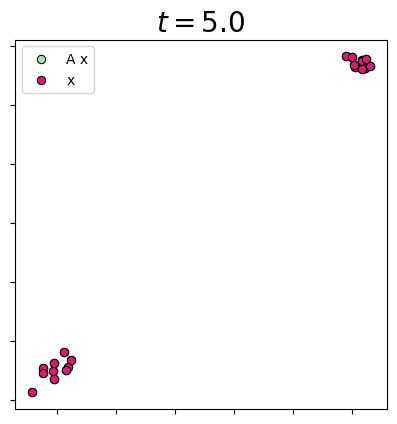

[[783.9111279   83.03835458]
 [794.23114926  93.43822631]]
Time 5.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


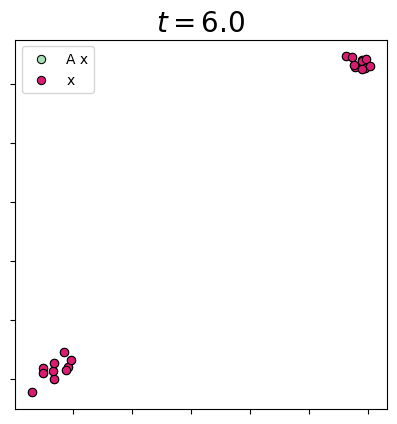

[[2001.37305365  -31.67621306]
 [2011.69307501  -21.27634132]]
Time 6.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


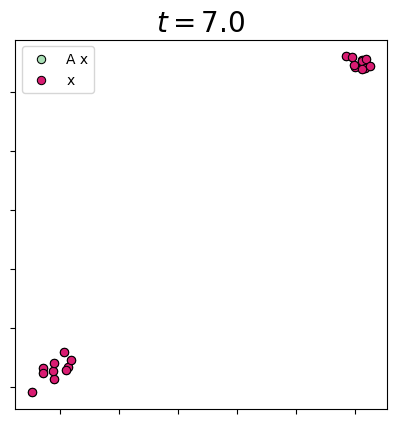

[[5155.82597218 -615.41431509]
 [5166.14599354 -605.01444335]]
Time 7.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


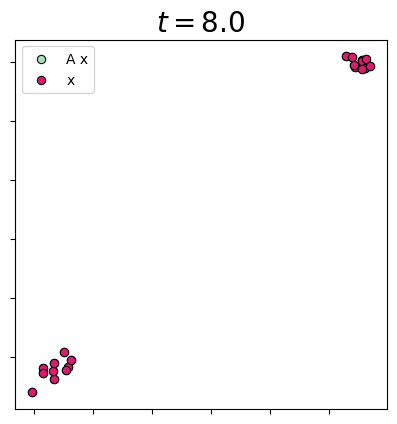

[[13419.01477957 -2730.02669614]
 [13408.69475821 -2740.42656787]]
Time 8.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


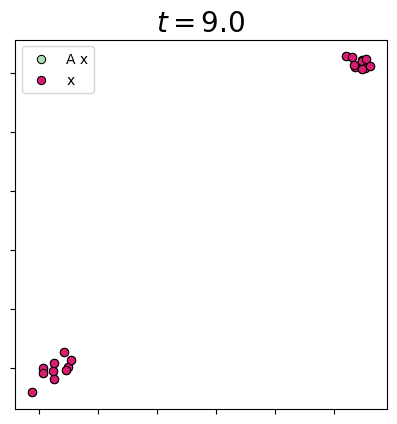

[[35166.54920373 -9578.06968797]
 [35176.86922509 -9567.66981624]]
Time 9.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


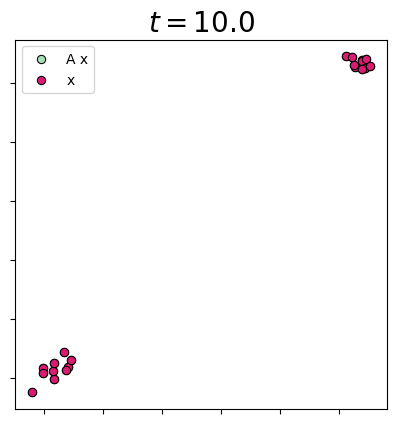

[[ 92882.68888074 -30235.33215271]
 [ 92872.36885938 -30245.73202444]]
Time 10.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


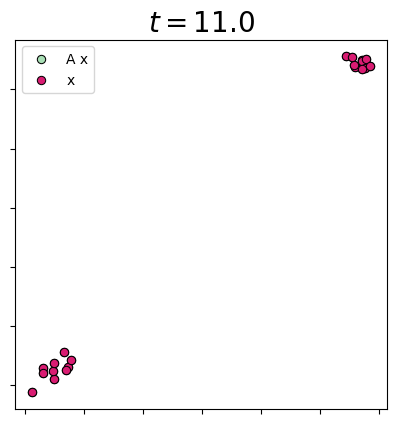

[[246633.33835596 -90465.09687807]
 [246623.01833459 -90475.4967498 ]]
Time 11.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


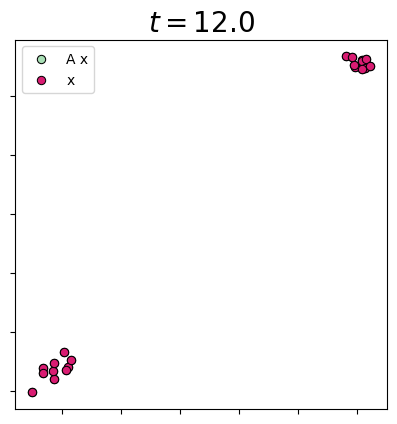

[[ 657709.76605809 -261989.28424331]
 [ 657720.08607945 -261978.88437157]]
Time 12.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


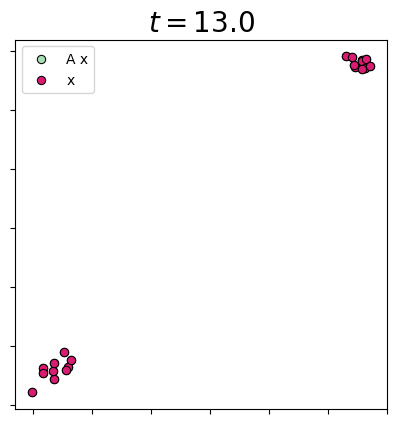

[[1759754.73918478 -742966.80785169]
 [1759765.05920614 -742956.40797996]]
Time 13.00: Silhouette Score = 0.9629 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


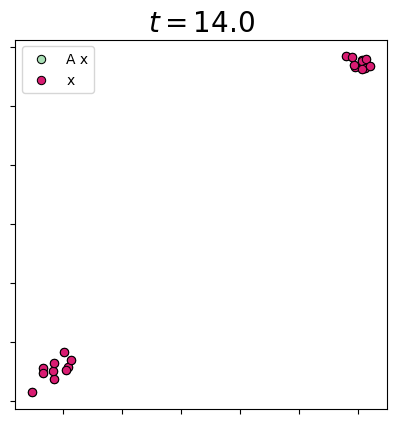

[[ 4720026.03617288 -2077650.52745361]
 [ 4720015.71615151 -2077660.92732534]]
Time 14.00: Silhouette Score = 0.9628 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


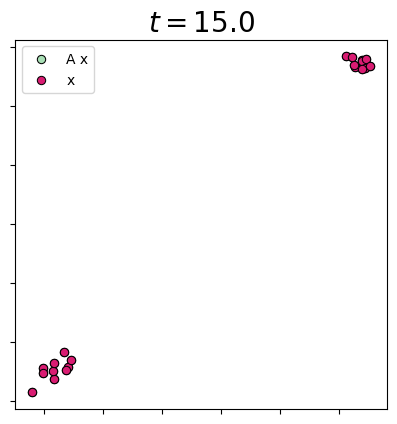

[[12683614.6878567  -5754164.53460798]
 [12683604.36783534 -5754174.93447971]]
Time 15.00: Silhouette Score = 0.9643 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


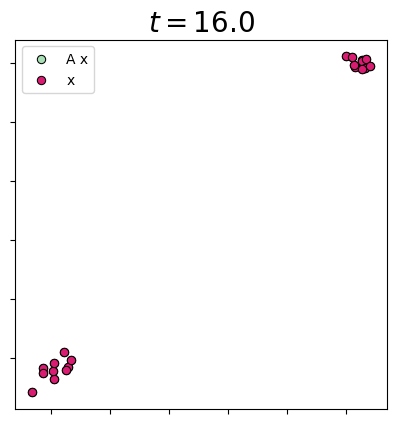

[[ 34130868.13061023 -15828394.39959363]
 [ 34130878.45063159 -15828383.9997219 ]]
Time 16.00: Silhouette Score = 0.9626 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


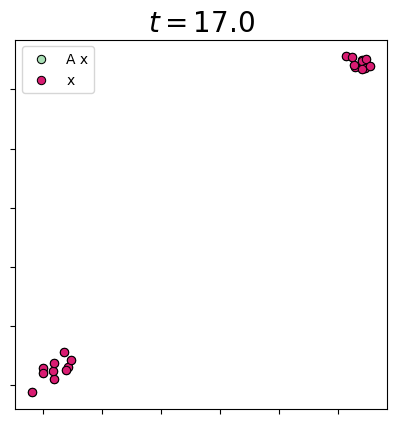

[[ 91939944.72158101 -43329271.09679112]
 [ 91939934.40155967 -43329281.49666286]]
Time 17.00: Silhouette Score = 0.9708 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


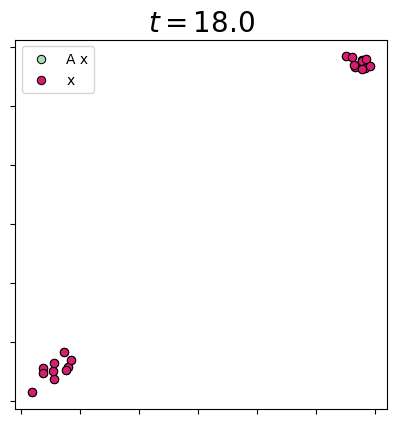

[[ 2.47855217e+08 -1.18196705e+08]
 [ 2.47855207e+08 -1.18196715e+08]]
Time 18.00: Silhouette Score = 0.9141 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


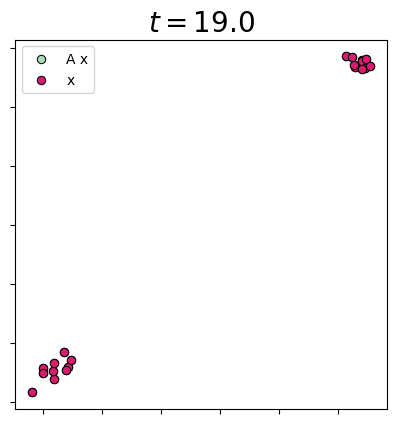

[[ 6.68563458e+08 -3.21606651e+08]
 [ 6.68563469e+08 -3.21606641e+08]]
Time 19.00: Silhouette Score = 0.8170 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


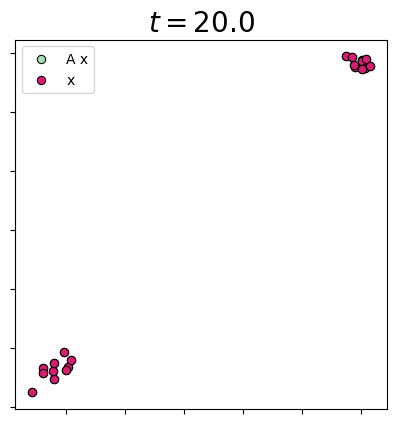

[[ 1.80415374e+09 -8.73450960e+08]
 [ 1.80415373e+09 -8.73450971e+08]]
Time 20.00: Silhouette Score = 0.3311 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


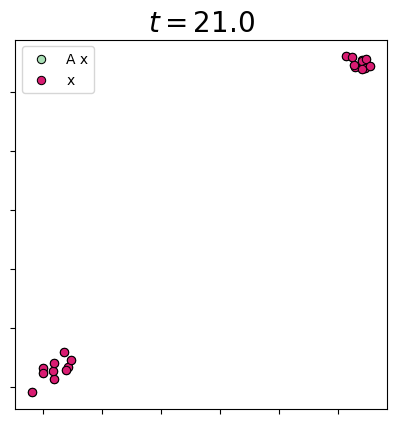

[[ 4.87015488e+09 -2.36897988e+09]
 [ 4.87015487e+09 -2.36897989e+09]]
Time 21.00: Silhouette Score = -0.2234 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


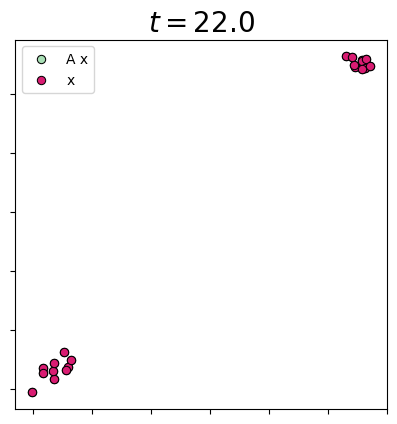

[[ 1.31496633e+10 -6.41874613e+09]
 [ 1.31496633e+10 -6.41874612e+09]]
Time 22.00: Silhouette Score = 0.1024 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


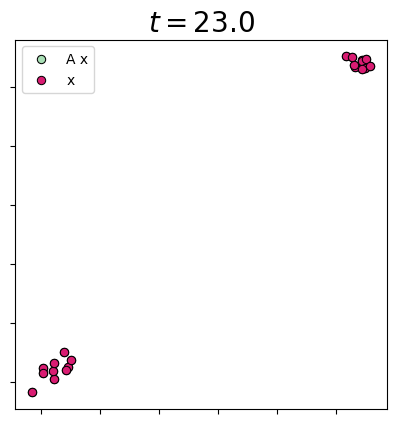

[[ 3.55109753e+10 -1.73787871e+10]
 [ 3.55109753e+10 -1.73787871e+10]]
Time 23.00: Silhouette Score = 0.2136 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


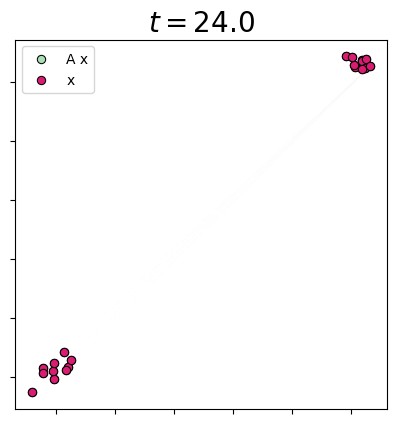

[[ 9.59106838e+10 -4.70276288e+10]
 [ 9.59106838e+10 -4.70276288e+10]]
Time 24.00: Silhouette Score = -0.4305 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


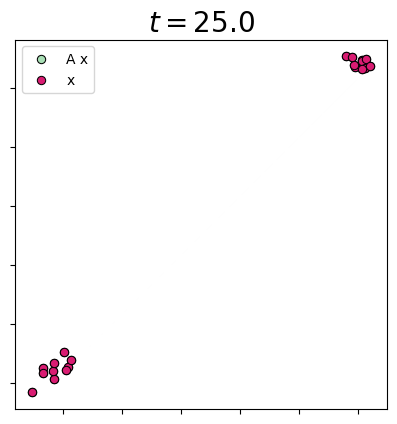

[[ 2.59067651e+11 -1.27207508e+11]
 [ 2.59067651e+11 -1.27207507e+11]]
Time 25.00: Silhouette Score = 0.0165 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


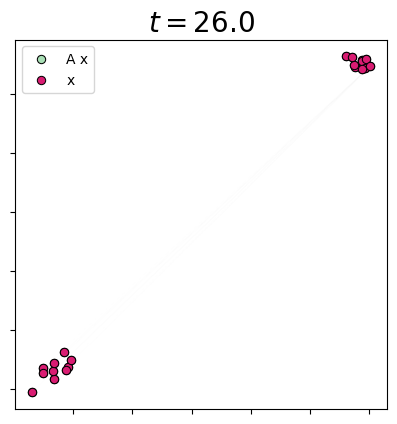

[[ 6.99826475e+11 -3.43988466e+11]
 [ 6.99826475e+11 -3.43988466e+11]]
Time 26.00: Silhouette Score = -0.1167 Distance between cluster centers = 14.6513


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


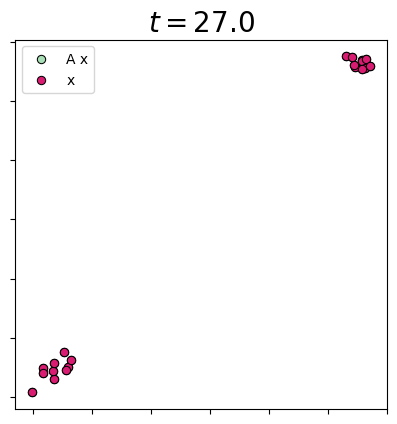

[[ 1.89056016e+12 -9.29993693e+11]
 [ 1.89056016e+12 -9.29993693e+11]]
Time 27.00: Silhouette Score = -0.1516 Distance between cluster centers = 14.6511


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


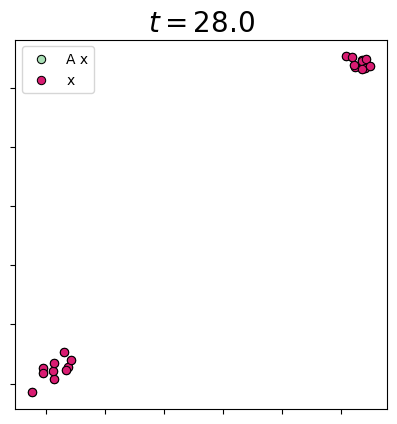

[[ 5.10749134e+12 -2.51388758e+12]
 [ 5.10749134e+12 -2.51388758e+12]]
Time 28.00: Silhouette Score = -0.3269 Distance between cluster centers = 14.6515


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


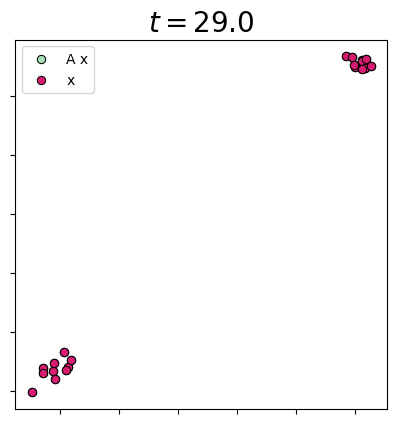

[[ 1.37986745e+13 -6.79453456e+12]
 [ 1.37986745e+13 -6.79453456e+12]]
Time 29.00: Silhouette Score = 0.2401 Distance between cluster centers = 14.6512


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


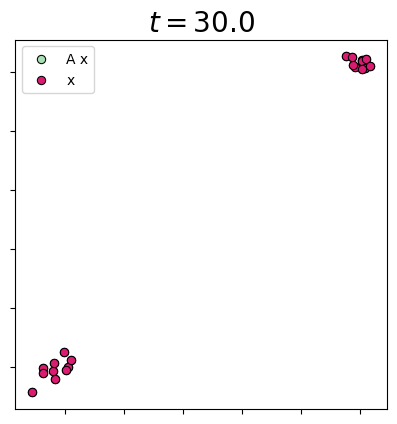

[[ 3.72800452e+13 -1.83626390e+13]
 [ 3.72800452e+13 -1.83626390e+13]]
Time 30.00: Silhouette Score = -0.1467 Distance between cluster centers = 14.6505


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


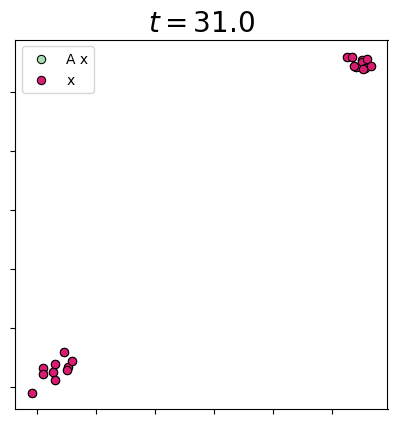

[[ 1.0072155e+14 -4.9622884e+13]
 [ 1.0072155e+14 -4.9622884e+13]]
Time 31.00: Silhouette Score = 0.3075 Distance between cluster centers = 14.6560


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


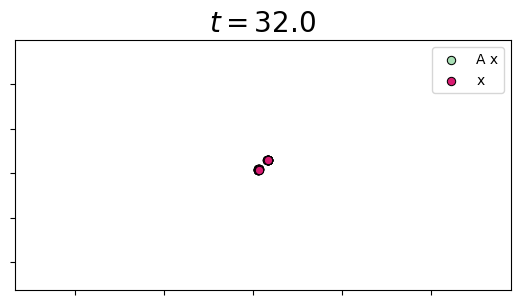

[[ 2.72128159e+14 -1.34093531e+14]
 [ 2.72128159e+14 -1.34093531e+14]]
Time 32.00: Silhouette Score = -0.1747 Distance between cluster centers = 14.6505


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


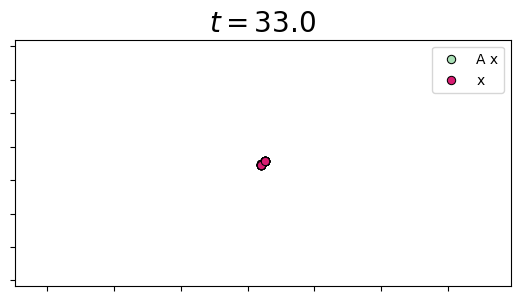

[[ 7.35238700e+14 -3.62341472e+14]
 [ 7.35238700e+14 -3.62341472e+14]]
Time 33.00: Silhouette Score = 0.1002 Distance between cluster centers = 14.6725


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


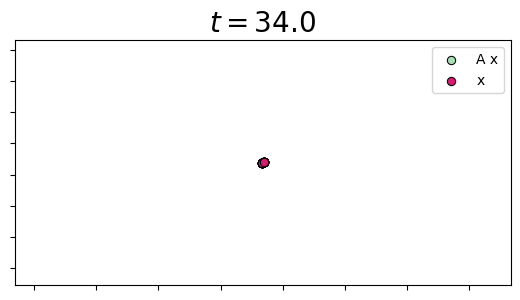

[[ 1.98648843e+15 -9.79076679e+14]
 [ 1.98648843e+15 -9.79076679e+14]]
Time 34.00: Silhouette Score = -0.4011 Distance between cluster centers = 14.5843


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


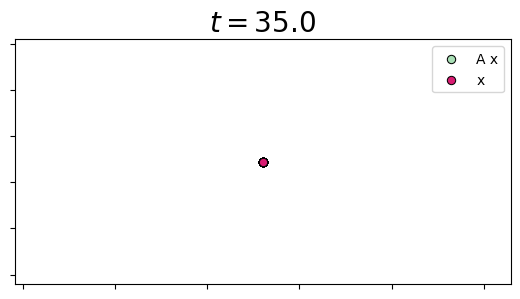

[[ 5.36717554e+15 -2.64549419e+15]
 [ 5.36717554e+15 -2.64549419e+15]]
Time 35.00: Silhouette Score = 0.2389 Distance between cluster centers = 14.5000


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


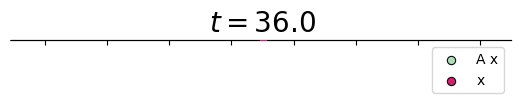

[[ 1.45013054e+16 -7.14809941e+15]
 [ 1.45013054e+16 -7.14809941e+15]]
Time 36.00: Silhouette Score = 0.0000 Distance between cluster centers = 15.6205


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


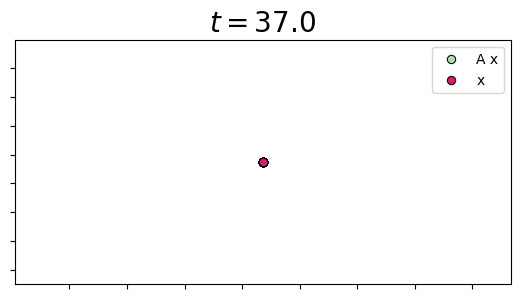

[[ 3.91804605e+16 -1.93138860e+16]
 [ 3.91804605e+16 -1.93138860e+16]]
Time 37.00: Silhouette Score = -1.0000 Distance between cluster centers = 11.3137


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


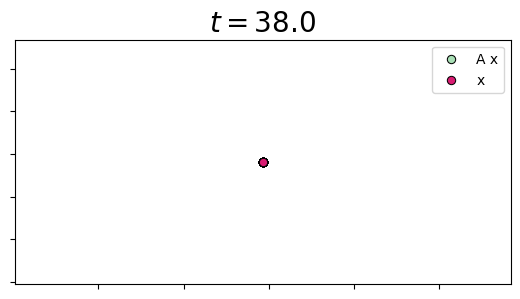

[[ 1.05860227e+17 -5.21849498e+16]
 [ 1.05860227e+17 -5.21849498e+16]]
Time 38.00: Silhouette Score = 0.0000 Distance between cluster centers = 8.0000


/scratch/720018/ipykernel_1554999/3724501836.py:7: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


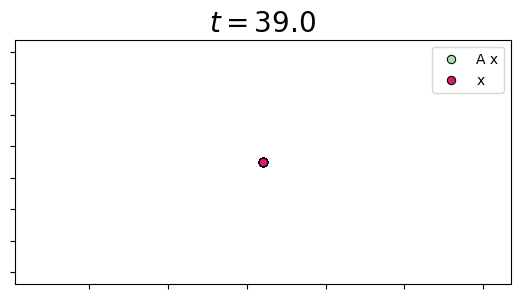

[[ 2.86020214e+17 -1.40999737e+17]
 [ 2.86020214e+17 -1.40999737e+17]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [112]:
# simulation loop

for l, t in enumerate(integration_time):
    if l<num_steps-1:
        # Attention matrix
        # attention = [[compute_attention(A, x, i, j, n) for j in range(n)] for i in range(n)]
        attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]
        attention = np.array(attention)
        # print(np.linalg.matrix_rank(attention))
        
        label_size = 0
        if round(t % viz_cadence, 10) == 0:
            # ensure the visualization works under larger dimension
            if d > 2:
                pca = PCA(n_components=2)
                reduced_x = pca.fit_transform(x[:, l, :])

                plt.scatter(reduced_x[:, 0], reduced_x[:, 1], c="#d91c72", alpha=1, marker='o', linewidth=0.75, edgecolors='black')
                plt.title(f't = {round(t, 2)}')
                plt.show()
            else:
                fig = plt.figure()
                ax = fig.add_subplot(1, 1, 1)
                label_size = 8
                plt.rcParams['xtick.labelsize'] = label_size
                plt.rcParams['ytick.labelsize'] = label_size 

                ax.set_aspect('equal', adjustable='box')

                # the projected A x
                plt.scatter([np.matmul(A, x[i,l])[0] for i in range(n)],
                            [np.matmul(A, x[i,l])[1] for i in range(n)],
                            c="#a8deb5", 
                            alpha=1, 
                            marker = 'o', 
                            linewidth=0.75, 
                            edgecolors='black', 
                            zorder=3,
                            label='A x')

                # these are the pinks ones
                plt.scatter([x[i,l][0] for i in range(n)],
                            [x[i,l][1] for i in range(n)],
                            c="#d91c72", 
                            alpha=1, 
                            marker = 'o', 
                            linewidth=0.75, 
                            edgecolors='black', 
                            zorder=3,
                            label='x')

                plt.title(r'$t={t}$'.format(t=str(round(t, 2))), fontsize=20)

                for i in range(n):
                    for j in range(n):
                        if attention[i][j]>1e-4 and i!=j:
                            plt.plot([np.matmul(A, x[i,l])[0], x[j,l][0]], 
                                      [np.matmul(A, x[i,l])[1], x[j,l][1]],
                                      linewidth=attention[i][j]*1e-6,
                                      color="black")

                ax.set_yticklabels([])
                ax.set_xticklabels([])
            plt.legend()
            plt.show()
            
        if round(t % kmeans_cadence, 10) == 0:
            positions = x[:, l, :]
            kmeans = KMeans(n_clusters=2).fit(positions)
            labels_pred = kmeans.labels_
            cluster_centers = kmeans.cluster_centers_
            print(cluster_centers)
            score = silhouette_score(positions, labels_pred)
            distance_between_centers = np.linalg.norm(cluster_centers[0] - cluster_centers[1])
            print(f"Time {t:.2f}: Silhouette Score = {score:.4f} Distance between cluster centers = {distance_between_centers:.4f}")
            
            
        
        # update v if classification
        if classification_task:
            logits = np.matmul(A, x[:, l, :].T).T  # Shape: (n, d)
            logits = np.matmul(logits, V)           # Shape: (n, d)
            # For binary classification, reduce to single logit
            logits = logits[:, 0]                   # Shape: (n,)

            # Compute Loss and Probabilities
            probs = 1 / (1 + np.exp(-logits))       # Sigmoid activation
            loss = -np.mean(labels * np.log(probs + 1e-7) + (1 - labels) * np.log(1 - probs + 1e-7))
            print(f"Time {t:.2f}: Loss = {loss}")

            # Compute Gradient of Loss w.r.t V
            # Gradient for V: x_i * (prob_i - y_i)
            grad_V = np.zeros_like(V)
            for i in range(n):
                grad_V += np.outer(logits[i] * (probs[i] - labels[i]), x[i, l, :])
            grad_V /= n  # Average over particles

            # Update V using Gradient Descent
            V -= learning_rate * grad_V
            
            # maintain symmetry in V
            eigvals, eigvecs = np.linalg.eigh(V)
            eigvals = np.maximum(eigvals, 0)
            V = eigvecs @ np.diag(eigvals) @ eigvecs.T
        
        # perform particle position update
        x = euler_update(attention, V, x, n, dt)

## Experiments with deliberate clustering

Idea: if we force clusters in V and A, so that they are aligned with clusters, the hypothesis is that they will get more drastically separated from eachother with time

In [5]:
colors = ["#a8deb5", "#a5d8ff", "#ffb3c1", "#c1caff"] # cikir per cluster

In [19]:
cluster_labels = np.array([
        i for i in range(num_clusters) for _ in range(particles_per_cluster)
    ])

Time 0.00: Attention Matrix Rank = 11


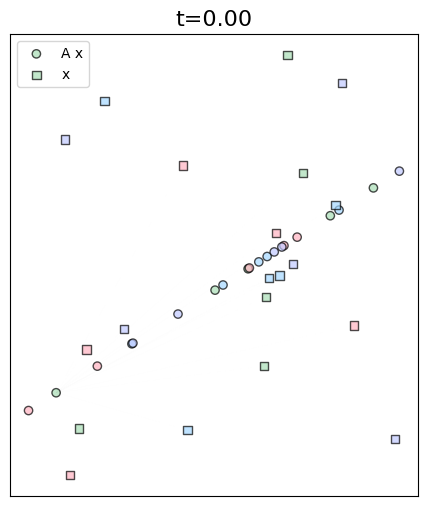

Time 0.10: Attention Matrix Rank = 11
Time 0.20: Attention Matrix Rank = 11
Time 0.30: Attention Matrix Rank = 11
Time 0.40: Attention Matrix Rank = 11
Time 0.50: Attention Matrix Rank = 12


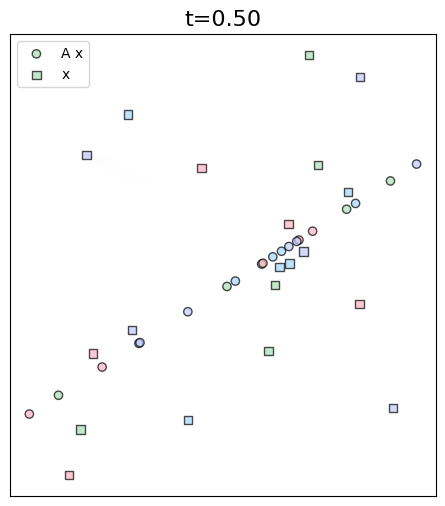

Time 0.60: Attention Matrix Rank = 12
Time 0.70: Attention Matrix Rank = 12
Time 0.80: Attention Matrix Rank = 12
Time 0.90: Attention Matrix Rank = 12
Time 1.00: Attention Matrix Rank = 13


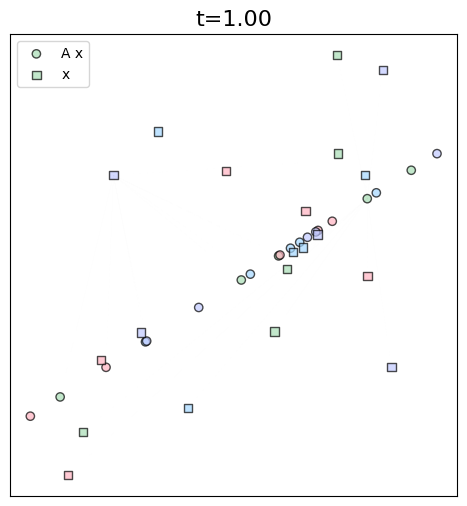

Time 1.10: Attention Matrix Rank = 13
Time 1.20: Attention Matrix Rank = 13
Time 1.30: Attention Matrix Rank = 14
Time 1.40: Attention Matrix Rank = 14
Time 1.50: Attention Matrix Rank = 15


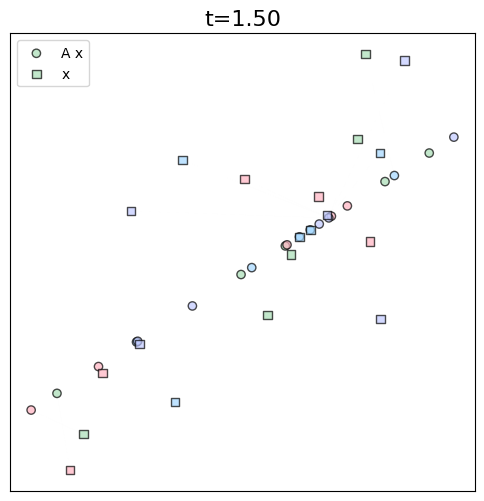

Time 1.60: Attention Matrix Rank = 15
Time 1.70: Attention Matrix Rank = 16
Time 1.80: Attention Matrix Rank = 16
Time 1.90: Attention Matrix Rank = 16
Time 2.00: Attention Matrix Rank = 17


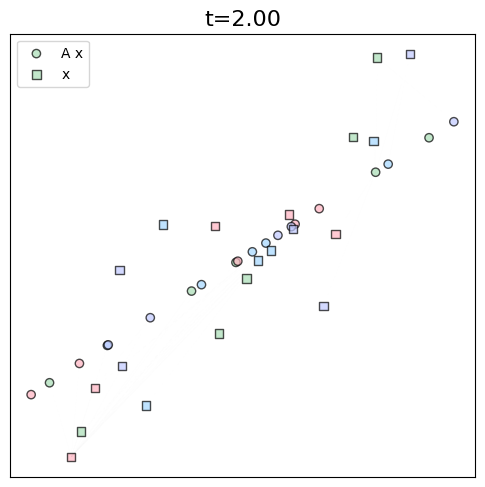

Time 2.10: Attention Matrix Rank = 17
Time 2.20: Attention Matrix Rank = 17
Time 2.30: Attention Matrix Rank = 16
Time 2.40: Attention Matrix Rank = 16
Time 2.50: Attention Matrix Rank = 15


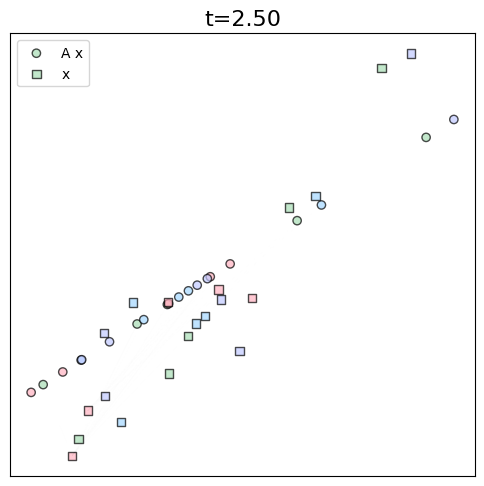

Time 2.60: Attention Matrix Rank = 14
Time 2.70: Attention Matrix Rank = 13
Time 2.80: Attention Matrix Rank = 12
Time 2.90: Attention Matrix Rank = 12
Time 3.00: Attention Matrix Rank = 11


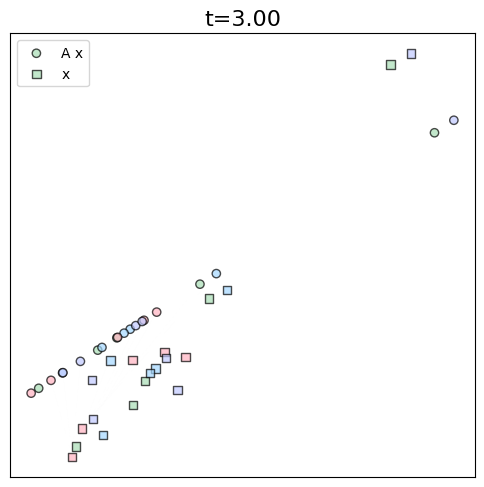

Time 3.10: Attention Matrix Rank = 10
Time 3.20: Attention Matrix Rank = 9
Time 3.30: Attention Matrix Rank = 9
Time 3.40: Attention Matrix Rank = 8
Time 3.50: Attention Matrix Rank = 8


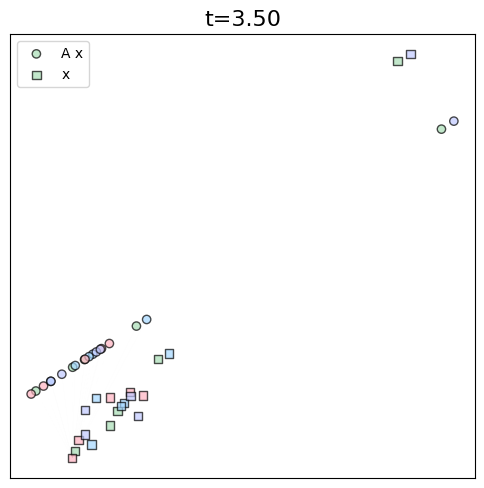

Time 3.60: Attention Matrix Rank = 7
Time 3.70: Attention Matrix Rank = 7
Time 3.80: Attention Matrix Rank = 7
Time 3.90: Attention Matrix Rank = 6
Time 4.00: Attention Matrix Rank = 6


/scratch/710071/ipykernel_3916969/516167009.py:8: RuntimeWarning: overflow encountered in exp
  np.exp(np.dot(A @ x[i, l], x[k, l] - x[j, l]))


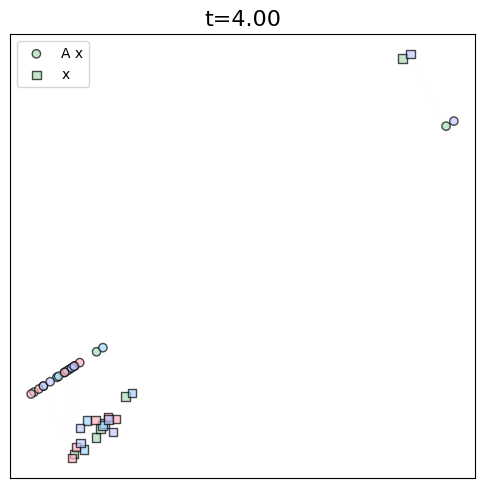

Time 4.10: Attention Matrix Rank = 5
Time 4.20: Attention Matrix Rank = 5
Time 4.30: Attention Matrix Rank = 5
Time 4.40: Attention Matrix Rank = 5
Time 4.50: Attention Matrix Rank = 5


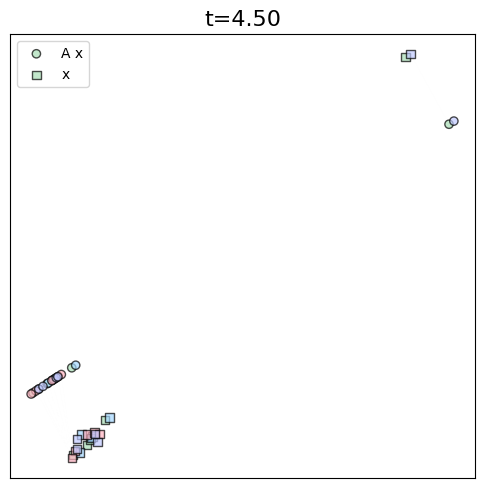

Time 4.60: Attention Matrix Rank = 4
Time 4.70: Attention Matrix Rank = 4
Time 4.80: Attention Matrix Rank = 4
Time 4.90: Attention Matrix Rank = 4
Time 5.00: Attention Matrix Rank = 4


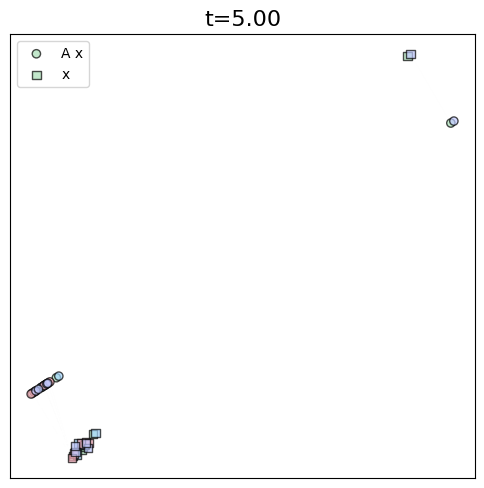

Time 5.10: Attention Matrix Rank = 4
Time 5.20: Attention Matrix Rank = 4
Time 5.30: Attention Matrix Rank = 4
Time 5.40: Attention Matrix Rank = 4
Time 5.50: Attention Matrix Rank = 3


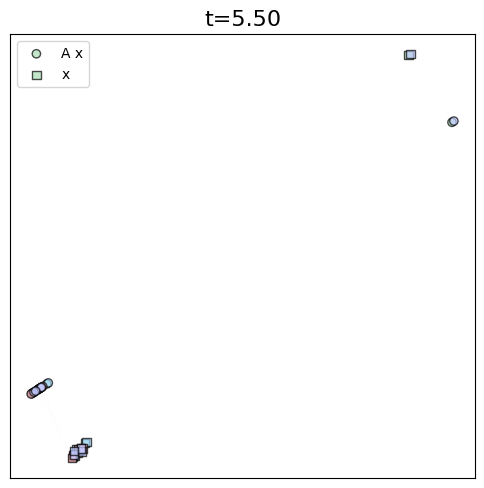

Time 5.60: Attention Matrix Rank = 3
Time 5.70: Attention Matrix Rank = 3
Time 5.80: Attention Matrix Rank = 3
Time 5.90: Attention Matrix Rank = 3
Time 6.00: Attention Matrix Rank = 3


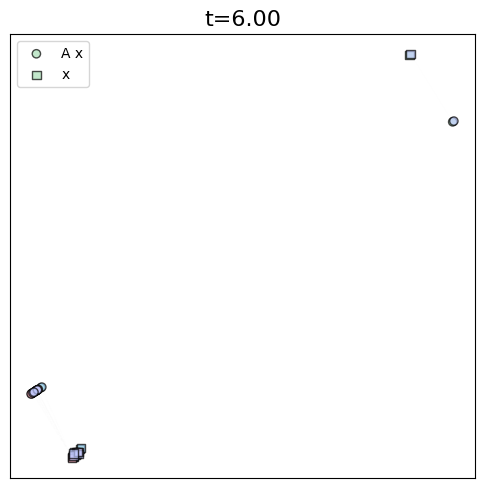

Time 6.10: Attention Matrix Rank = 2
Time 6.20: Attention Matrix Rank = 2
Time 6.30: Attention Matrix Rank = 2
Time 6.40: Attention Matrix Rank = 2
Time 6.50: Attention Matrix Rank = 2


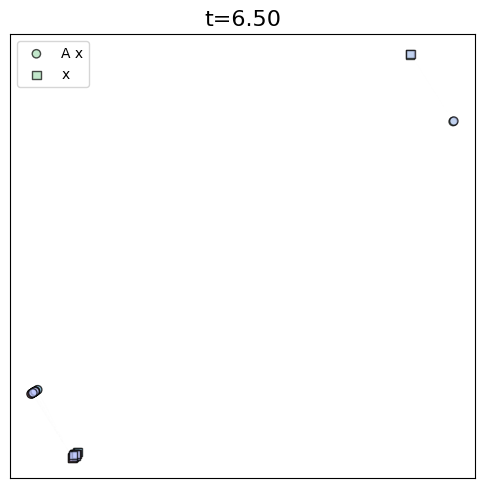

Time 6.60: Attention Matrix Rank = 2
Time 6.70: Attention Matrix Rank = 2
Time 6.80: Attention Matrix Rank = 2
Time 6.90: Attention Matrix Rank = 2
Time 7.00: Attention Matrix Rank = 2


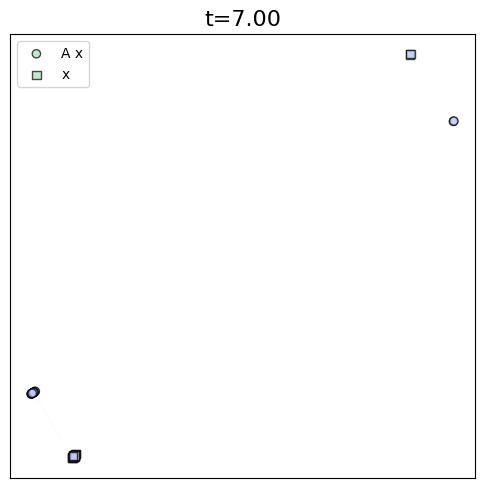

Time 7.10: Attention Matrix Rank = 2
Time 7.20: Attention Matrix Rank = 2
Time 7.30: Attention Matrix Rank = 2
Time 7.40: Attention Matrix Rank = 2
Time 7.50: Attention Matrix Rank = 2


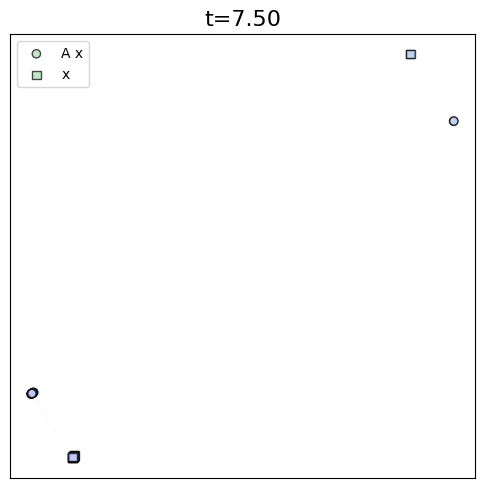

Time 7.60: Attention Matrix Rank = 2
Time 7.70: Attention Matrix Rank = 2
Time 7.80: Attention Matrix Rank = 2
Time 7.90: Attention Matrix Rank = 2
Time 8.00: Attention Matrix Rank = 2


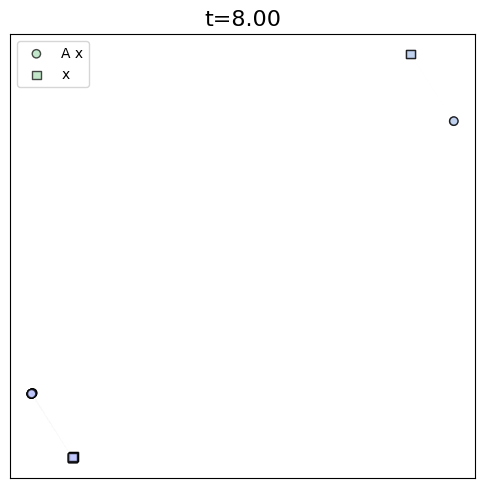

Time 8.10: Attention Matrix Rank = 2
Time 8.20: Attention Matrix Rank = 2
Time 8.30: Attention Matrix Rank = 2
Time 8.40: Attention Matrix Rank = 2
Time 8.50: Attention Matrix Rank = 2


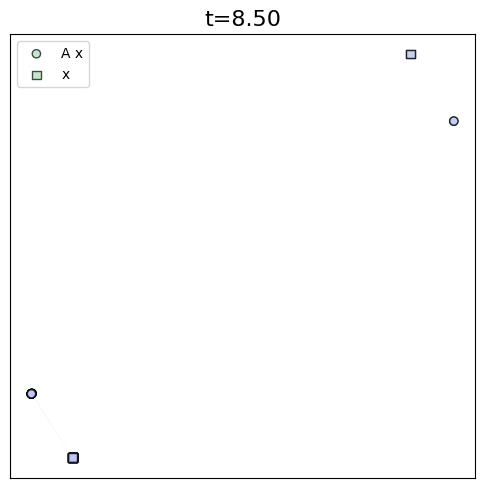

Time 8.60: Attention Matrix Rank = 2
Time 8.70: Attention Matrix Rank = 2
Time 8.80: Attention Matrix Rank = 2
Time 8.90: Attention Matrix Rank = 2
Time 9.00: Attention Matrix Rank = 2


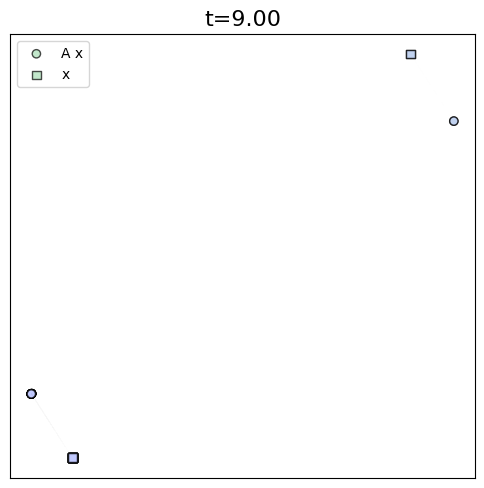

Time 9.10: Attention Matrix Rank = 2
Time 9.20: Attention Matrix Rank = 2
Time 9.30: Attention Matrix Rank = 2
Time 9.40: Attention Matrix Rank = 2
Time 9.50: Attention Matrix Rank = 2


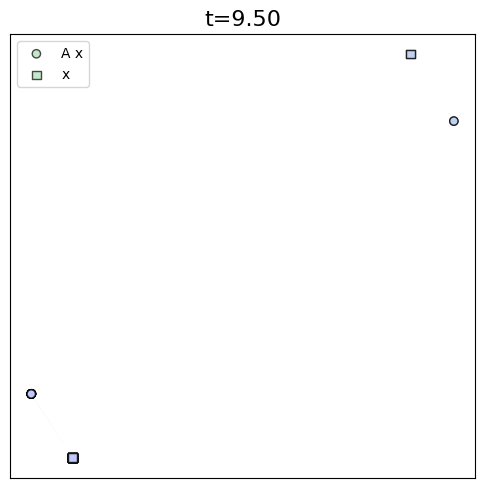

Time 9.60: Attention Matrix Rank = 2
Time 9.70: Attention Matrix Rank = 2
Time 9.80: Attention Matrix Rank = 2
Time 9.90: Attention Matrix Rank = 2


In [21]:
# Simulation Loop
for l, t in enumerate(integration_time):
    if l < num_steps - 1:
        # Compute Attention Matrix
        attention_matrix = np.array([
            [
                1 / np.sum([
                    np.exp(np.dot(A @ x[i, l], x[k, l] - x[j, l]))
                    for k in range(n)
                ]) 
                for j in range(n)
            ] 
            for i in range(n)
        ])
        rank = np.linalg.matrix_rank(attention_matrix)
        print(f"Time {t:.2f}: Attention Matrix Rank = {rank}")
        
        # Update Transformation Matrix A (modular, can be swapped out)
#         A = update_A(attention_matrix, x[:, l, :], n, d)
        
#         # Update Transformation Influence Matrix V (modular, can be swapped out)
#         V = update_V(A, num_clusters)
        
        # Visualization at every 0.5 time units
        if np.isclose(t % 0.5, 0, atol=1e-8):
            visualize(
                x=x[:, l, :],
                A=A,
                attention_matrix=attention_matrix,
                cluster_labels=cluster_labels,
                colors=colors,
                t=t,
                show=True
            )
        
        # update particle state
        x = euler_update(attention, V, x, n, dt)

## Rank Collapse

In [17]:
def rk4(V, x, n):
    "Runge-Katta forth degree"
    for i in range(n):
        k1 = dt*np.matmul(V, x[i][l])
        k2 = dt*np.matmul(V, x[i][l] + 0.5*k1)
        k3 = dt*np.matmul(V, x[i][l] + 0.5*k2)
        k4 = dt*np.matmul(V, x[i][l] + k3)
        dynamics = (1/6)*(k1 + 2*k2 + 2*k3 + k4)
        x[i][l+1] = x[i][l] + dynamics
    return x

In [20]:
# we can do far fewer iterations when illustrating rank collapse
T = 2.0
num_steps = int(T/dt) + 1
integration_time = np.linspace(0, T, num_steps)

# much higher dim
d = 100
A = init_A(d)
V = init_V(d)
x = init_x(n, d, num_steps)

20


/scratch/720018/ipykernel_1554999/3988804566.py:4: RuntimeWarning: overflow encountered in exp
  attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]


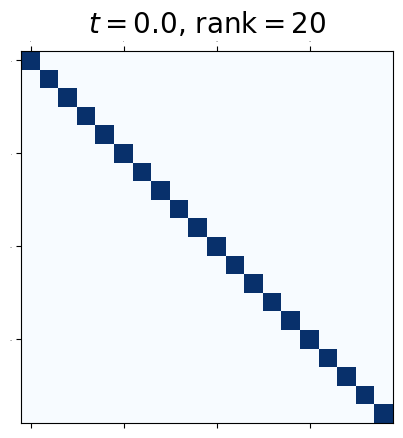

14


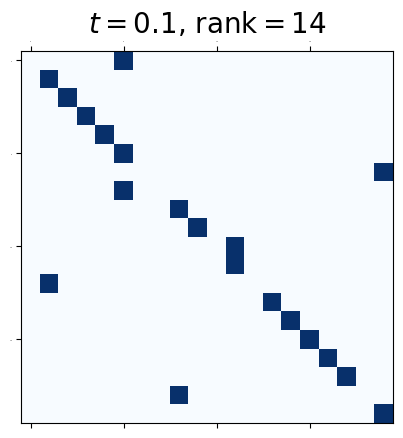

5


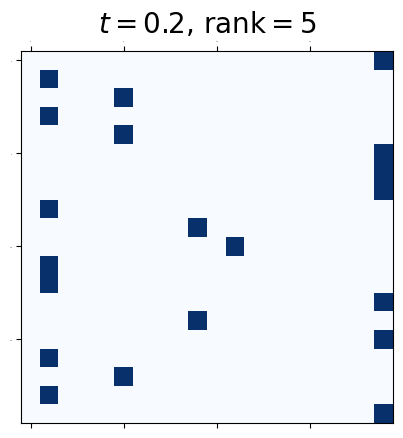

4


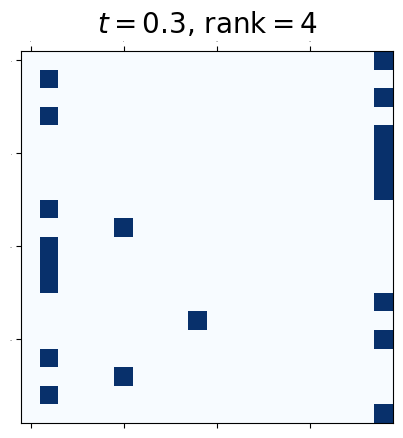

3


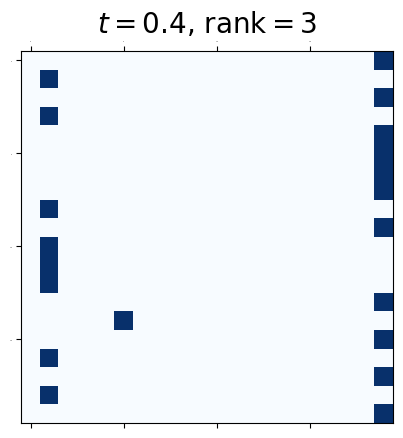

3


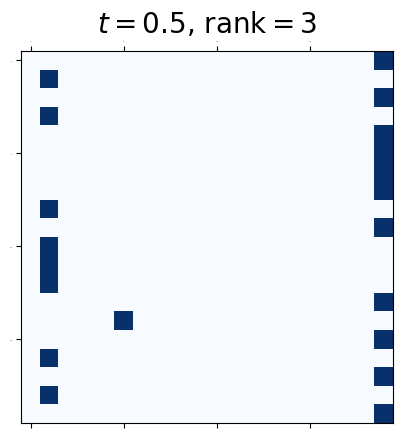

2


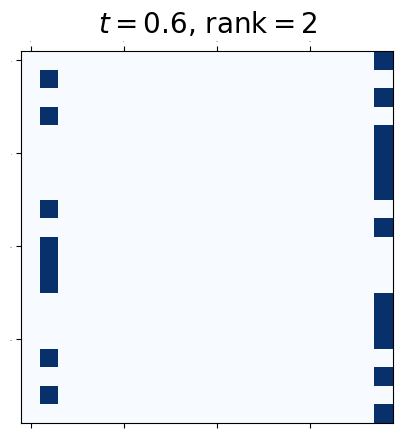

2


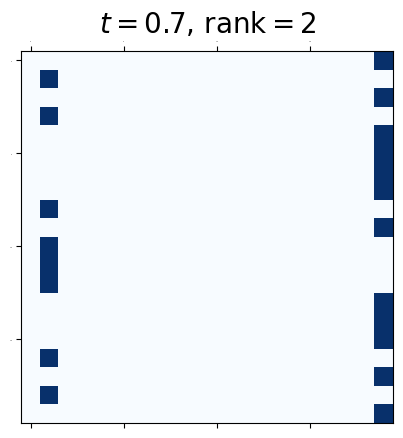

2


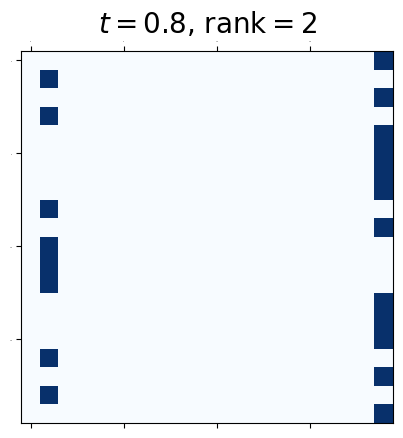

2


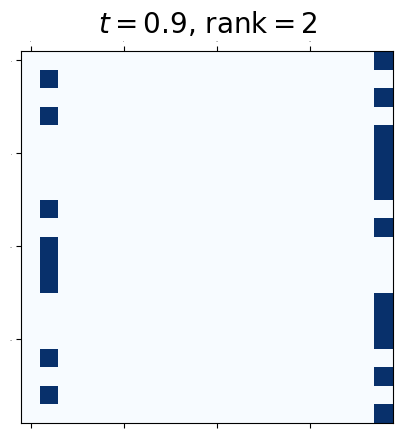

2


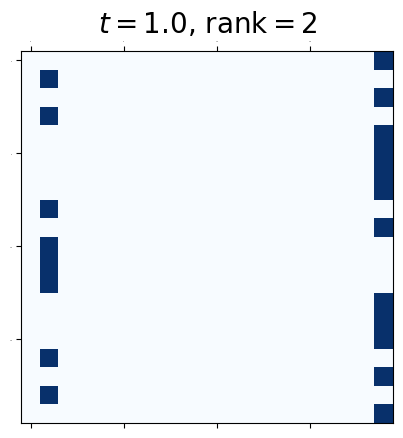

2


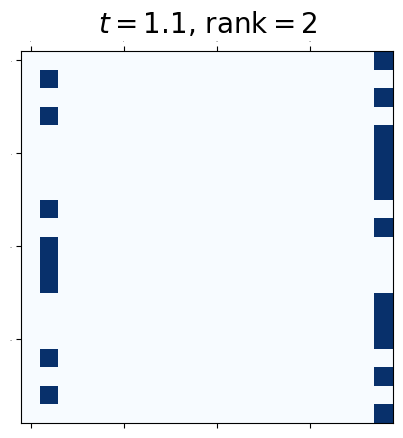

2


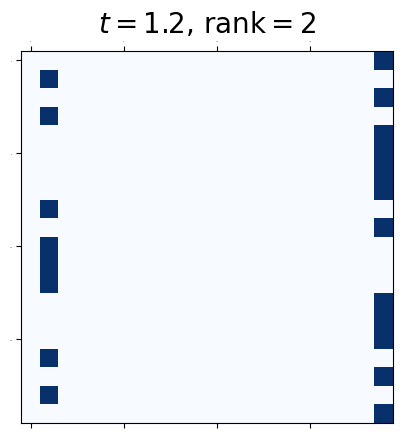

2


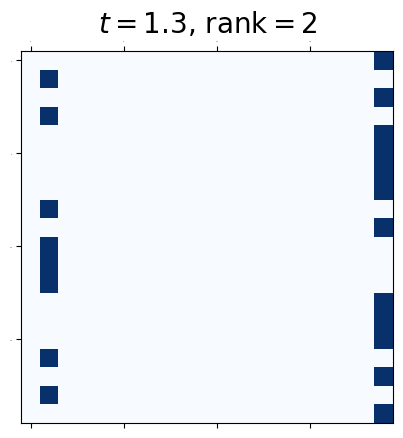

2


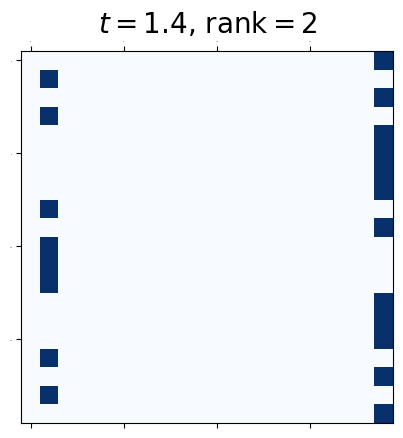

2


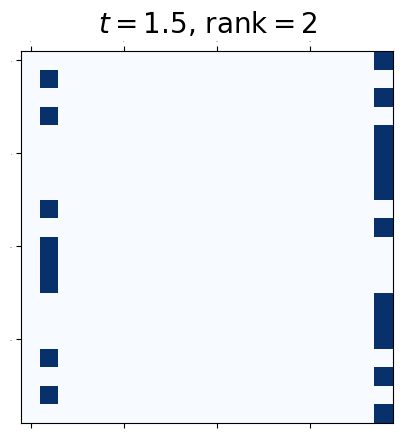

2


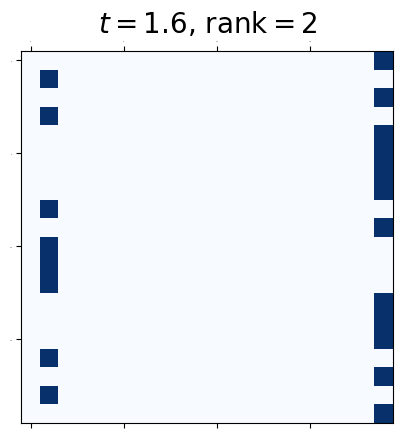

2


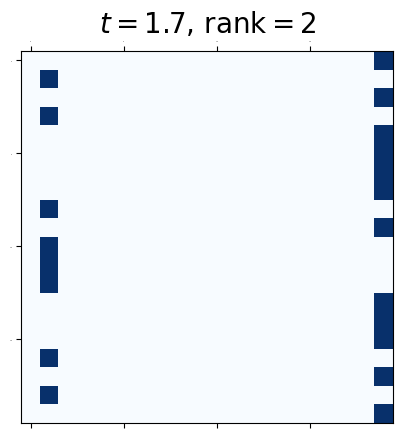

2


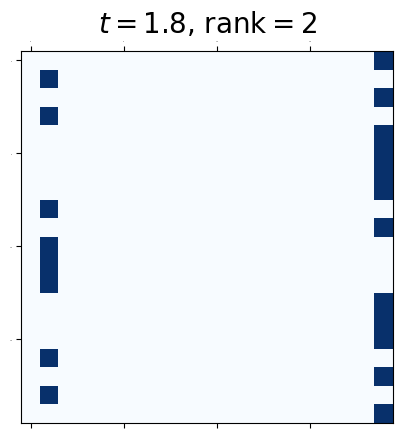

2


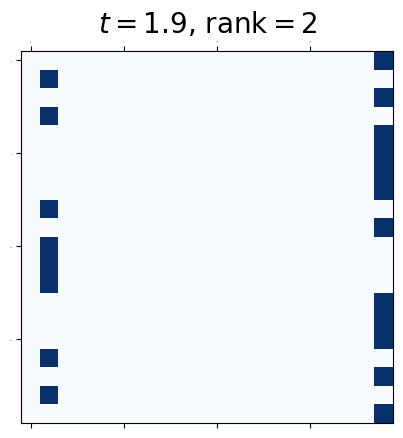

In [21]:
# simulation
for l, t in enumerate(integration_time):
    if l<num_steps-1:
        attention = [[1/np.sum([np.exp(np.dot(np.matmul(A, x[i][l]), x[k][l]-x[j][l])) for k in range(n)]) for j in range(n)] for i in range(n)]
        print(np.linalg.matrix_rank(attention))

        label_size = 0
        plt.matshow(attention, cmap="Blues")
        plt.rcParams['xtick.labelsize'] = label_size
        plt.rcParams['ytick.labelsize'] = label_size
        plt.title(r'$t={t}$, rank$={r}$'.format(t=str(round(t, 2)), r=str(np.linalg.matrix_rank(attention))), fontsize=20)
        plt.show()

        plt.clf()
        plt.close()
            
        # perform update, this one is rkhf
        x = rk4(V, x, n) 